In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
from stochastic_proc.midprice import BrownianMidprice, HistoricalMidprice
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
from stochastic_proc.dynamics import LimitOrderDynamics
from envs.trading import TradingEnv
from agents.BaseAgent import AvellanedaStoikovAgent
from agents.GLFT import GLFTAgent
from rewards.RewardFunctions import PnLReward, InventoryQuadraticPenalty, SpreadRegularizer, SumReward
from utils.plot_single import run_and_log, plot_single_episode
from utils.plot_batch import simulate_batch, plot_batch
from utils.plot_lite import plot_trajectory, generate_results_table_and_hist, compare_poisson_vs_hawkes
from utils.calibration import hawkes_params
from utils.calibration import hawkes_params, glft_half_spreads
from envs.SB3tradingenv import SB3TradingVecEnv
from data.feed import *

In [ ]:
from stochastic_proc.base import ProcessBase

preprocessed_data, data_loader = preprocess_l2_data(file_path)
data_loader.reset()  # Correct usage

def get_midprice_from_snapshot(snap):
    best_ask = float(snap['asks'][0])
    best_bid = float(snap['bids'][0])
    return 0.5 * (best_ask + best_bid)

def get_base_intensities_from_snapshot(snap, levels_for_volume=1, alpha=1e-4):
    ask_sizes = np.array(snap['asks'][25:], dtype=float)
    bid_sizes = np.array(snap['bids'][25:], dtype=float)
    k = max(1, min(levels_for_volume, len(ask_sizes)))
    A_ask_t = alpha * np.sum(ask_sizes[:k])  
    A_bid_t = alpha * np.sum(bid_sizes[:k])  
    return A_bid_t, A_ask_t

class ExternalSeriesMidprice(ProcessBase):
    """
    Replays a precomputed midprice path per trajectory, matching ProcessBase.
    Now includes sigma as part of the class to satisfy AvellanedaStoikovAgent.
    """
    def __init__(self, mid_paths, dt: float, T: float, sigma: float, seed=None):
        mid_paths = np.asarray(mid_paths, dtype=float)   # shape [N, M]
        assert mid_paths.ndim == 2, "mid_paths must be [N, M]"
        self.paths = mid_paths
        self.N, self.M = self.paths.shape
        self.sigma = sigma  # Store sigma to access it later
        super().__init__(init_state=np.array([self.paths[0, 0]]),
                         num_traj=self.N, dt=dt, T=T, seed=seed)

    @property
    def price(self) -> np.ndarray:
        return self.state[:, 0]

    def reset(self):
        super().reset()
        self.state[:, 0] = self.paths[:, 0]

    def step(self, **kwargs):
        idx = min(self.t_idx, self.M - 1)
        self.state[:, 0] = self.paths[:, idx]
        self.t_idx += 1
        return {"price": self.state[:, 0]}


class DataDrivenArrivals(ProcessBase):
    def __init__(self, lam_bid_paths, lam_ask_paths, dt: float, T: float, seed=None):
        lam_bid_paths = np.asarray(lam_bid_paths, dtype=float) 
        lam_ask_paths = np.asarray(lam_ask_paths, dtype=float)
        assert lam_bid_paths.shape == lam_ask_paths.shape, "Shapes must match"
        self.lbid = lam_bid_paths
        self.lask = lam_ask_paths
        self.N, self.M = self.lbid.shape
        init = np.array([self.lbid[0, 0], self.lask[0, 0]])  
        super().__init__(init_state=init, num_traj=self.N, dt=dt, T=T, seed=seed)

    def reset(self):
        super().reset()
        self.state[:, 0] = self.lbid[:, 0]
        self.state[:, 1] = self.lask[:, 0]

    def step(self, **kwargs):
        idx = min(self.t_idx, self.M - 1)
        self.state[:, 0] = self.lbid[:, idx]
        self.state[:, 1] = self.lask[:, idx]
        p = np.clip(self.state * self.dt, 0.0, 1.0)
        u = self.rng.uniform(size=self.state.shape)
        arrivals = (u < p)  
        self.t_idx += 1
        return {"arrivals": arrivals}


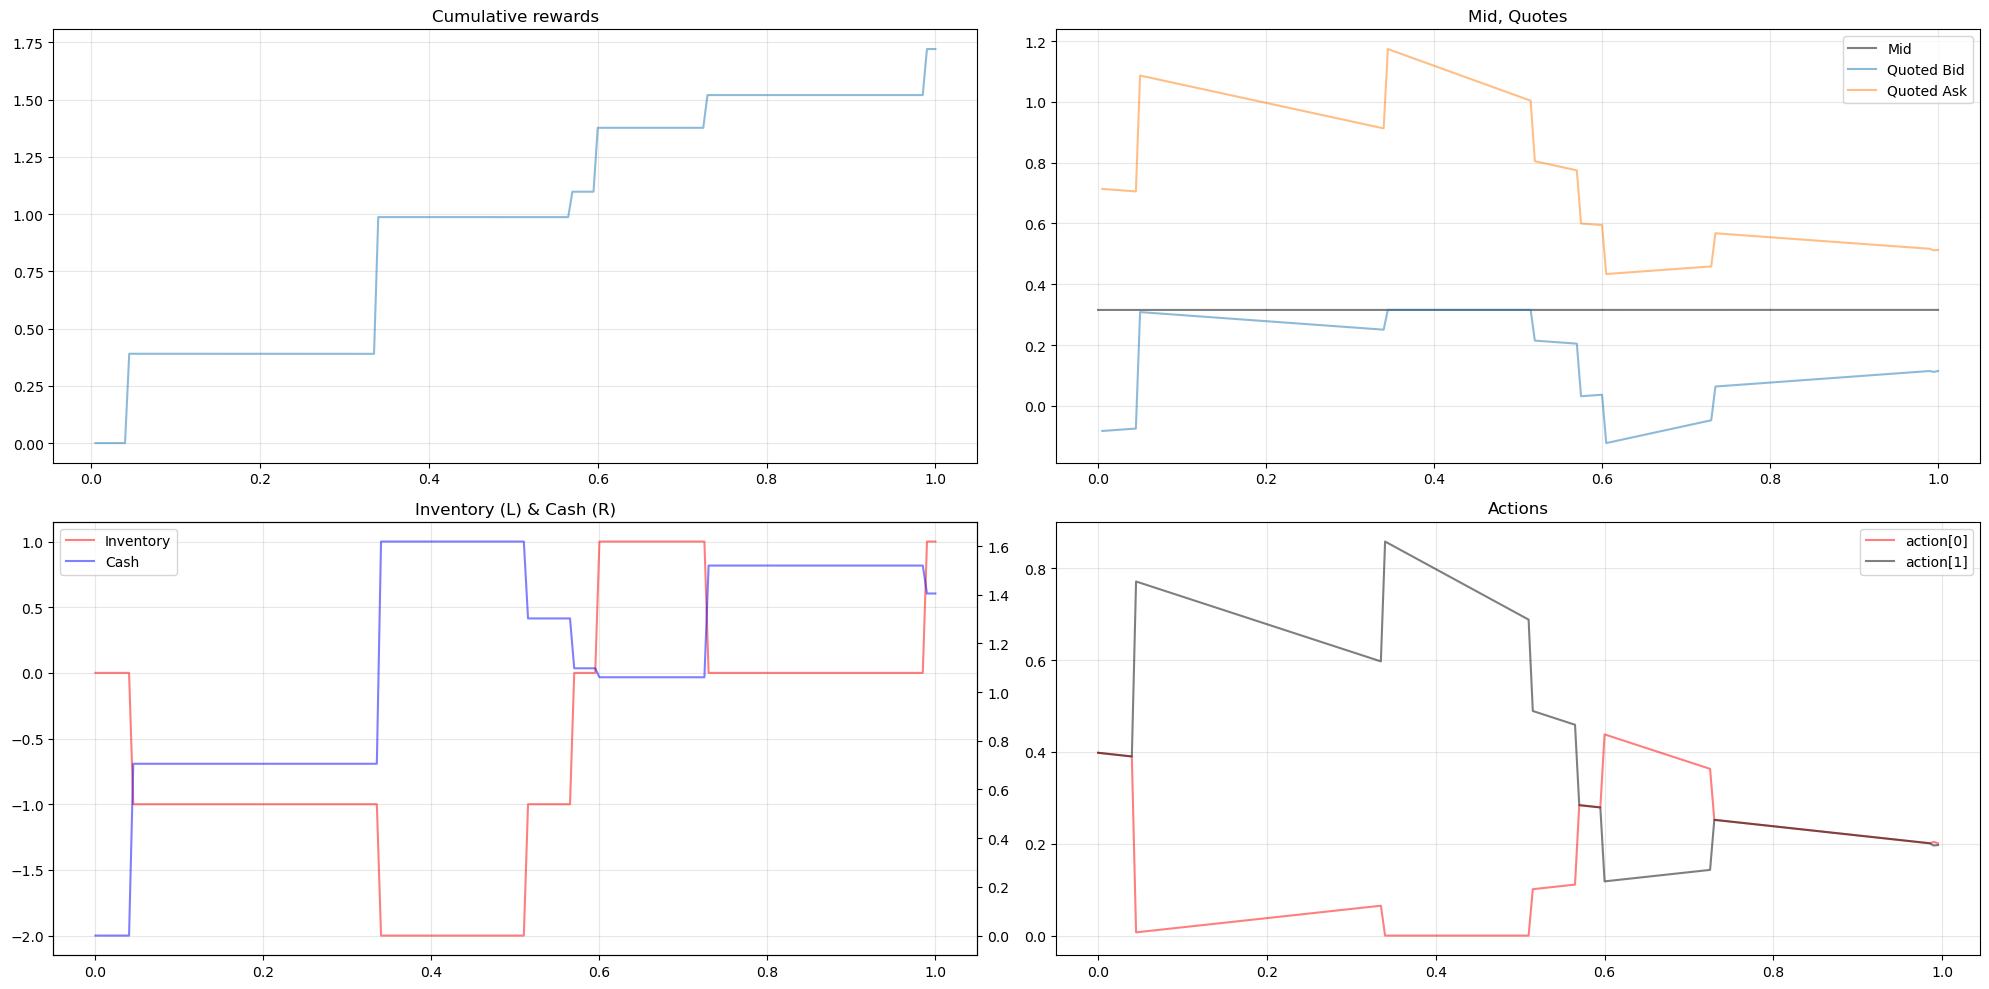

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140, 5, 1
dt = T / M

# Collect midprice and intensity paths from L2 data
mid_series, A_bid_series, A_ask_series = [], [], []
for _ in range(M):
    snap = data_loader.step()
    if snap is None:
        break
    mid_series.append(get_midprice_from_snapshot(snap))
    A_bid, A_ask = get_base_intensities_from_snapshot(snap, levels_for_volume=1, alpha=1e-4)
    A_bid_series.append(A_bid)
    A_ask_series.append(A_ask)

M = min(M, len(mid_series))  # safety if file is shorter

mid_paths = np.array(mid_series, dtype=float)[None, :]
A_bid_paths = np.array(A_bid_series, dtype=float)[None, :]
A_ask_paths = np.array(A_ask_series, dtype=float)[None, :]

mid = ExternalSeriesMidprice(mid_paths, dt=dt, T=T, sigma=sigma, seed=SEED)
arr = DataDrivenArrivals(A_bid_paths, A_ask_paths, dt=dt, T=T, seed=SEED)

dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)

plot_trajectory(env, agent, show_reservation=False)